In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
%load_ext rpy2.ipython

In [134]:
# Load all the data
dir = "/Users/gustxsr/Documents/Stanford/PoldrackLab/Vagus Nerve and Cognition/eyeNARPS/NARPS_MG_asc_processed"
saccade_data = []

for file in os.listdir(dir):
    if file.endswith("saccade_trials.csv"):
        csv = pd.read_csv(os.path.join(dir, file))
        csv['sub'] = int(file[4:7])
        saccade_data.append(csv)

saccade_data = pd.concat(saccade_data)

In [136]:
# remove outliers from the velocity and the pv?
# also, dont run the fit on data with little numbers. 
saccade_data = saccade_data.query("trial.notna() & pv < 350")

In [137]:
behav = pd.read_csv("/Users/gustxsr/Documents/Stanford/PoldrackLab/github/analysisNARPS/data/narps_behav_data.csv")
trial_id = [i for i in range(1, 257)]*behav['sub'].nunique()
behav['trial'] = trial_id
behav['uncertain'] = behav['response_int'].apply(lambda x: 1 if x == 2 or x == 3 else 0)
behav = behav.loc[:, ~behav.columns.str.contains('^Unnamed')]

# Create column called dist_indiff
behav['dist_indiff'] = np.abs(behav['gain'] - behav['loss']) / np.sqrt(2)

In [138]:
saccade_data = saccade_data.merge(behav, on=['sub', 'trial'])
# remove no response trials
saccade_data = saccade_data.query("response_int.notna()")

In [140]:
saccade_data["one"] = 1


In [139]:
hmap_data = saccade_data.groupby(['gain', 'loss'])['one'].count().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'L Rate'})

plt.xlabel("Loss")
plt.ylabel("Gain")

,trial,dur,ampl,pv,sub,run,condition,gain,loss,RT,accept,response_int,participant_response,uncertain,dist_indiff
0,65.0,19,1.35,91,95,2,equalIndifference,40,5,1.234,1,4.0,strongly_accept,0,24.748737
1,65.0,23,1.45,90,95,2,equalIndifference,40,5,1.234,1,4.0,strongly_accept,0,24.748737
2,65.0,25,2.19,157,95,2,equalIndifference,40,5,1.234,1,4.0,strongly_accept,0,24.748737
3,65.0,24,1.79,97,95,2,equalIndifference,40,5,1.234,1,4.0,strongly_accept,0,24.748737
4,65.0,30,0.09,75,95,2,equalIndifference,40,5,1.234,1,4.0,strongly_accept,0,24.748737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142324,64.0,40,2.40,174,71,1,equalIndifference,14,14,1.133,1,4.0,strongly_accept,0,0.000000
142325,64.0,37,1.65,131,71,1,equalIndifference,14,14,1.133,1,4.0,strongly_accept,0,0.000000
142326,64.0,48,2.12,171,71,1,equalIndifference,14,14,1.133,1,4.0,strongly_accept,0,0.000000
142327,64.0,25,2.76,206,71,1,equalIndifference,14,14,1.133,1,4.0,strongly_accept,0,0.000000


In [127]:
# fit a logitic function to the data

from scipy.optimize import curve_fit

def logistic(x, L, k):
    return L / (1 + np.exp(-k*(x))) - L / 2

def fit_logistic(data):
    popt, pcov = curve_fit(logistic, data['ampl'], data['pv'], p0=[400, 0.5])
    return popt, pcov

# params = {"L": [], "k": [], "gain": [], "loss": [], "dist_indiff" : []}
# for gain in saccade_data.query("condition == 'equalIndifference'")['gain'].unique():
#     for loss in saccade_data.query("condition == 'equalIndifference'")['loss'].unique():
#         popt, pcov = fit_logistic(saccade_data.query(f"condition == 'equalIndifference' & gain == {gain} & loss == {loss}"))
#         params["L"].append(popt[0])
#         params["k"].append(popt[1])
#         params["gain"].append(gain)
#         params["loss"].append(loss)
#         params["dist_indiff"].append(np.abs(gain - loss) / np.sqrt(2))

# do same as above but for response_int
params = {"L": [], "k": [], "response_int": [], "sub" : [], "condition" : []}
for sub in saccade_data['sub'].unique():
    for response_int in saccade_data.query(f"sub == {sub}")['response_int'].unique():
        popt, pcov = fit_logistic(saccade_data.query(f"sub == {sub} & response_int == {response_int}"))
        params["L"].append(popt[0])
        params["k"].append(popt[1])
        params["response_int"].append(response_int)
        params["sub"].append(sub)
        params["condition"].append(saccade_data.query(f"sub == {sub}")['condition'].unique()[0])

params = pd.DataFrame(params)

/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_16591/3774618654.py:9: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(logistic, data['ampl'], data['pv'], p0=[400, 0.5])


In [128]:
params = pd.DataFrame(params)

<Axes: xlabel='response_int', ylabel='k'>

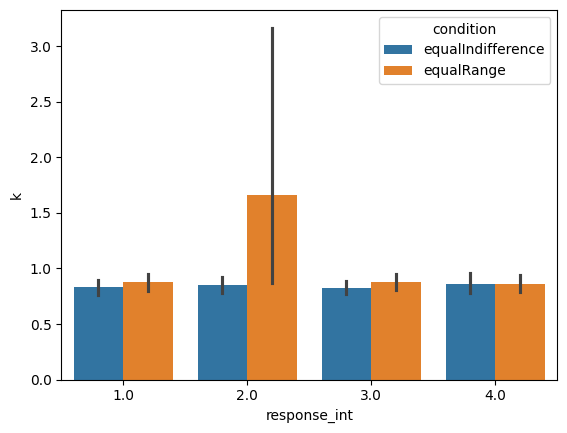

In [129]:
sns.barplot(x='response_int', y='k', data=params, hue = "condition")

In [124]:
params.query("k > 2")

,L,k,response_int,sub,condition
27,283.168359,5.007108,3.0,61,equalIndifference
135,354.521088,25.107225,1.0,71,equalIndifference
136,342.949501,3.916225,2.0,71,equalIndifference
159,367.274869,2.057971,4.0,79,equalIndifference
176,318.443343,2.323639,2.0,43,equalIndifference


In [133]:
%%R -i params
library(lme4)
library(lmerTest)

# set response_int as a factor
params$response_int <- as.factor(params$response_int)
model <- lm(L ~ response_int * condition, data=params)
summary(model)


Call:
lm(formula = L ~ response_int * condition, data = params)

Residuals:
     Min       1Q   Median       3Q      Max 


-203.221  -43.171    7.976   49.306  268.397 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        492.038     15.898  30.949   <2e-16 ***
response_int2                        2.758     22.282   0.124    0.902    
response_int3                        4.853     22.282   0.218    0.828    
response_int4                       -8.304     22.282  -0.373    0.710    
conditionequalRange                -19.369     22.483  -0.861    0.390    
response_int2:conditionequalRange  -28.746     31.807  -0.904    0.367    
response_int3:conditionequalRange   -5.681     31.807  -0.179    0.858    
response_int4:conditionequalRange   12.239     31.654   0.387    0.699    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 82.61 on 209 degrees of freedom
Multiple R-squared:  0.03437,	Adjusted R-squared:  0.002029 
F-statistic: 1.063 on 7 and 209 DF,  p-value: 0.3888



Text(50.722222222222214, 0.5, 'Gain')

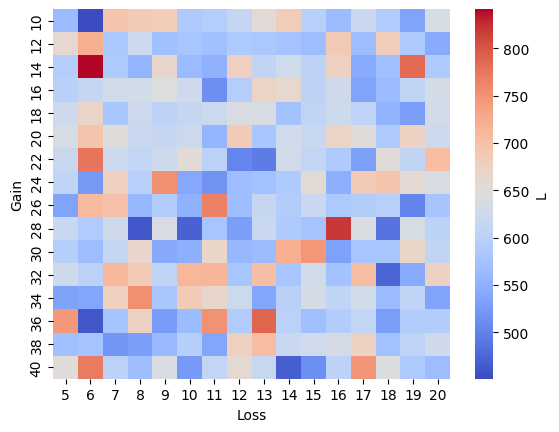

In [ ]:
hmap_data = params.groupby(['gain', 'loss'])['L'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'L Rate'})

plt.xlabel("Loss")
plt.ylabel("Gain")

Text(50.722222222222214, 0.5, 'Gain')

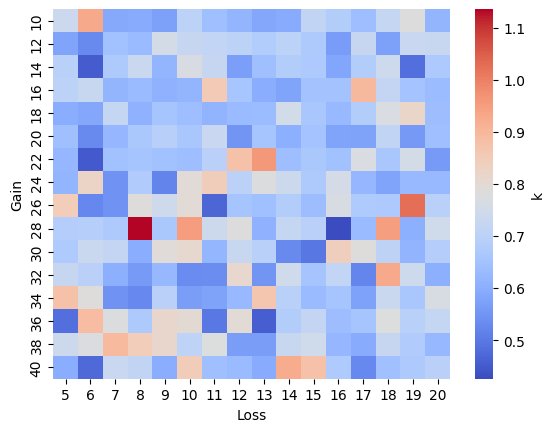

In [102]:
hmap_data = params.groupby(['gain', 'loss'])['k'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'k'})
plt.xlabel("Loss")
plt.ylabel("Gain")

<Axes: xlabel='ampl', ylabel='pv'>

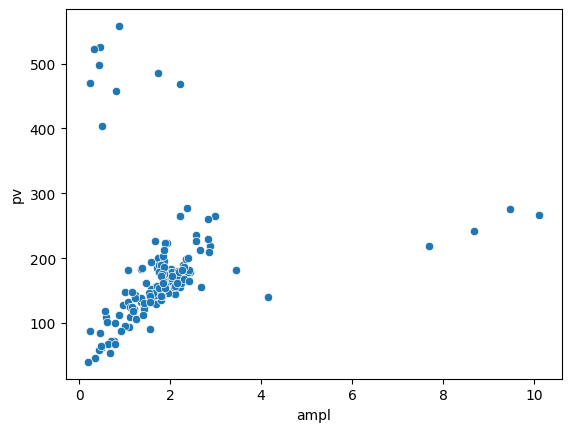

In [125]:
# plot fit of logistic function
# y = logistic(saccade_data.query("sub == 71 & response_int == 1")["ampl"], popt[0][0], popt[0][1])
sns.scatterplot(data=saccade_data.query("sub == 71 & response_int == 1"), x="ampl", y="pv")
# plt.scatter(saccade_data.query("gain == 40 & loss == 5")["ampl"], y, color='red')


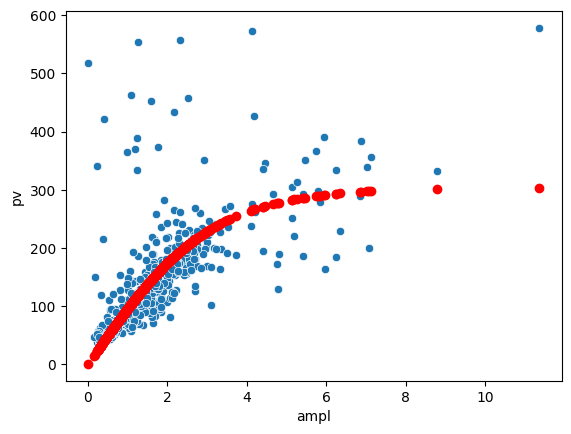

In [103]:
sns.scatterplot(data=saccade_data.query("gain == 16 & loss == 19"), x='ampl', y='pv')
y = logistic(saccade_data.query("gain == 16 & loss == 19")["ampl"].values, params.query("gain == 16 & loss == 19")["L"].values, params.query("gain == 16 & loss == 19")["k"].values)
plt.scatter(saccade_data.query("gain == 16 & loss == 19")["ampl"].values, y, color='red')


In [83]:
%%R -i saccade_data
library(lme4)
library(minpack.lm) # For nonlinear regression

In [84]:
%%R
logistic_function <- function(x, L, k) {
  return(L / (1 + exp(-k * x)) - L / 2)
}

In [92]:
%%R
Model <- function(ampl, L0, k0) 
{
    (L0 / (1 + exp(-k0 * ampl)) - L0 / 2)
}

In [93]:
%%R
# Define the nonlinear model
nlmod_simple <- nlmer(
  formula = pv ~ Model(ampl, L0, k0) ~ 1 | sub,
  data = saccade_data,
  start = list(L0 = 1, k0 = 1)
)

Error in nlformula(mc <- match.call()) : 
  is.numeric(nlpars <- start$nlpars) is not TRUE


RInterpreterError: Failed to parse and evaluate line '# Define the nonlinear model\nnlmod_simple <- nlmer(\n  formula = pv ~ Model(ampl, L0, k0) ~ 1 | sub,\n  data = saccade_data,\n  start = list(L0 = 1, k0 = 1)\n)\n'.
R error message: 'Error in nlformula(mc <- match.call()) : \n  is.numeric(nlpars <- start$nlpars) is not TRUE'

In [ ]:
%%R
nlmod_extended <- nlmer(
  y ~ ((L0 + beta_gain * gain + beta_loss * loss) / 
       (1 + exp(-(k0 + gamma_gain * gain + gamma_loss * loss) * x)) - 
       (L0 + beta_gain * gain + beta_loss * loss) / 2) ~ 1 | subject,
  data = data,
  start = list(L0 = 1, k0 = 1, beta_gain = 0, beta_loss = 0, gamma_gain = 0, gamma_loss = 0)
)

Error in nlformula(mc <- match.call()) : 
  is.numeric(nlpars <- start$nlpars) is not TRUE


RInterpreterError: Failed to parse and evaluate line 'nlmod_extended <- nlmer(\n  y ~ ((L0 + beta_gain * gain + beta_loss * loss) / \n       (1 + exp(-(k0 + gamma_gain * gain + gamma_loss * loss) * x)) - \n       (L0 + beta_gain * gain + beta_loss * loss) / 2) ~ 1 | subject,\n  data = data,\n  start = list(L0 = 1, k0 = 1, beta_gain = 0, beta_loss = 0, gamma_gain = 0, gamma_loss = 0)\n)\n'.
R error message: 'Error in nlformula(mc <- match.call()) : \n  is.numeric(nlpars <- start$nlpars) is not TRUE'

In [86]:
%%R
nlmod_extended <- nlmer(
  y ~ ((L0 + beta_gain * gain + beta_loss * loss) / 
       (1 + exp(-(k0 + gamma_gain * gain + gamma_loss * loss) * x)) - 
       (L0 + beta_gain * gain + beta_loss * loss) / 2) ~ 1 | subject,
  data = data,
  start = list(L0 = 1, k0 = 1, beta_gain = 0, beta_loss = 0, gamma_gain = 0, gamma_loss = 0)
)

Error in nlformula(mc <- match.call()) : 
  is.numeric(nlpars <- start$nlpars) is not TRUE


RInterpreterError: Failed to parse and evaluate line 'nlmod_extended <- nlmer(\n  y ~ ((L0 + beta_gain * gain + beta_loss * loss) / \n       (1 + exp(-(k0 + gamma_gain * gain + gamma_loss * loss) * x)) - \n       (L0 + beta_gain * gain + beta_loss * loss) / 2) ~ 1 | subject,\n  data = data,\n  start = list(L0 = 1, k0 = 1, beta_gain = 0, beta_loss = 0, gamma_gain = 0, gamma_loss = 0)\n)\n'.
R error message: 'Error in nlformula(mc <- match.call()) : \n  is.numeric(nlpars <- start$nlpars) is not TRUE'

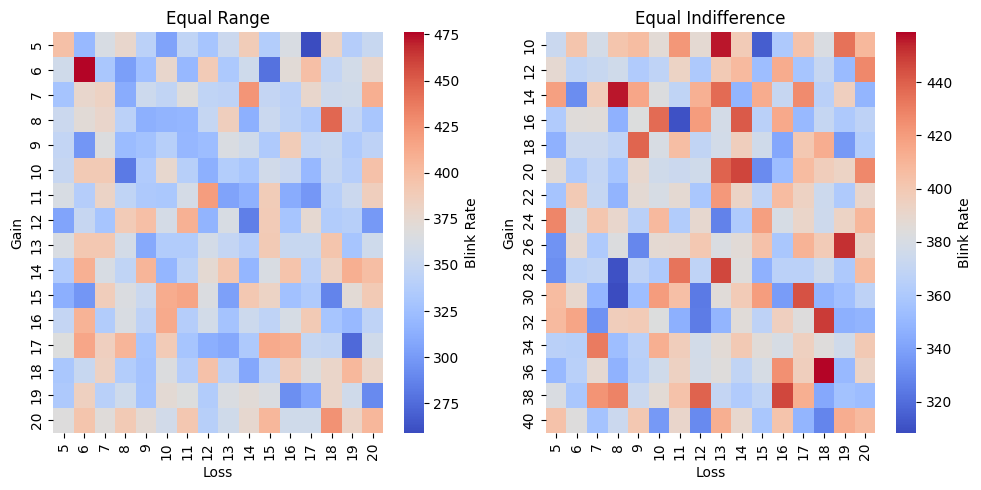

In [17]:
# Two figures: Blink rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = saccade_data.query("condition == 'equalRange'").groupby(['gain', 'loss'])['pv'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Blink Rate'}, ax = axs[0])
axs[0].set_title("Equal Range")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = saccade_data.query("condition == 'equalIndifference'").groupby(['gain', 'loss'])['pv'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Blink Rate'}, ax = axs[1])
axs[1].set_title("Equal Indifference")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

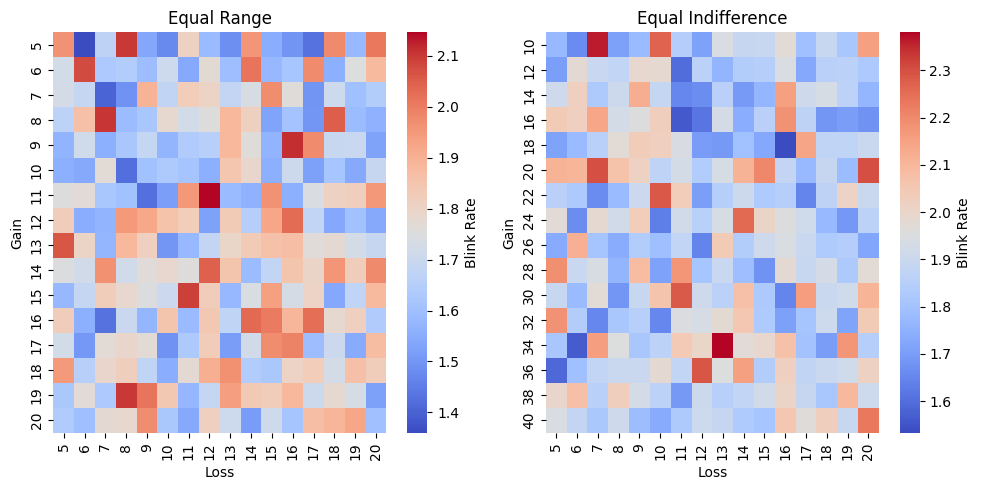

In [18]:
# Two figures: Blink rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = saccade_data.query("condition == 'equalRange'").groupby(['gain', 'loss'])['ampl'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Blink Rate'}, ax = axs[0])
axs[0].set_title("Equal Range")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = saccade_data.query("condition == 'equalIndifference'").groupby(['gain', 'loss'])['ampl'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Blink Rate'}, ax = axs[1])
axs[1].set_title("Equal Indifference")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()